# Data EDA and preprocessed
Source - https://www.kaggle.com/competitions/ai-defence-summer-school-2024/data

#### Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from nltk.tokenize import sent_tokenize
! pip install langdetect
from langdetect import detect

In [2]:
import spacy
!python -m spacy download ru_core_news_md
import ru_core_news_md
!python -m spacy download uk_core_news_md
import uk_core_news_md
from collections import Counter
from spacy.lang.ru.stop_words import STOP_WORDS

In [18]:
from nltk.corpus import stopwords
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ната\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ната\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
! pip install gensim
import gensim


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Data Loading

In [4]:
# Data with classes and ids
file_path = 'C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/data_defenders/data'
df_train = pd.read_csv(os.path.join(file_path, "train.csv"))
df_train.head()

,source_id,source_url,source_category
0,133653,https://twitter.com/IFR2022,AGGRESSIVE_INFORMATION
1,39644,https://t.me/warfakeskrm,RESTRAINED_INFORMATION
2,245395,https://t.me/od_patrolpolice,SAFE_CONTENT
3,252210,https://t.me/trech_kich,SPAM
4,226108,https://t.me/sitreports,RESTRAINED_INFORMATION


In [6]:
print("Unique channels ids:", df_train["source_id"].nunique())

Unique channels ids: 3260


In [8]:
print("Categories:")
print(df_train["source_category"].value_counts())

Categories:
AGGRESSIVE_INFORMATION                  1499
RESTRAINED_INFORMATION                  1174
AGGRESSIVE_MILITARY                      108
RESTRAINED_MILITARY                      107
SAFE_CONTENT                              91
ENTITIES_PROMOTING_VIOLENCE_AND_HATE      83
UNRECOGNIZED_REPUBLICS                    66
SPAM                                      54
VIOLENCE                                  31
COORDINATION_OF_ATTACKS                   23
PERSONAL_INFORMATION                      17
CYBER_ATTACK_COORDINATION                  7
Name: source_category, dtype: int64


In [9]:
# Data with messages
file = 'C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/data_defenders/data/messages.jsonl'
df_messages = pd.read_json(file, lines=True)
df_messages.head()

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type
0,253122,1415474509,https://www.youtube.com/watch?v=eR9FIPXffUw&li...,945.0,21,3.0,0,2024-06-25 11:50:25,POST
1,253122,1408345528,Плохо спится в белую петербургскую ночь. Котор...,1429.0,164,3.0,1,2024-06-24 21:32:54,POST
2,253122,1394795522,"«Давайте посмотрим внимательно, какую свободу ...",1158.0,84,9.0,1,2024-06-23 11:33:04,POST
3,253122,1364623985,К добрым словам Владимира Гельмана в мой адрес...,1071.0,86,2.0,0,2024-06-20 15:19:26,POST
4,253122,1364694325,"Известный политолог, профессор университета Хе...",1087.0,118,4.0,2,2024-06-20 15:14:28,POST


In [10]:
print("Unique channels ids:", df_messages["source_id"].nunique())

Unique channels ids: 4660


In [11]:
frequency = df_messages.groupby(['source_id', 'text']).size().reset_index(name='count')
print("Numbers of messages per id:", frequency["source_id"].value_counts())

Numbers of messages per id: 140396450    100
253435       100
253399       100
253405       100
253409       100
            ... 
121328196      1
120227848      1
70180807       1
39615          1
145007818      1
Name: source_id, Length: 4660, dtype: int64


In [12]:
# Data publication analises
df_messages["published_at"].dt.floor('d').value_counts()

2024-06-25    36615
2024-06-26    35199
2024-06-24    26355
2024-06-23    20097
2024-06-21    13401
              ...  
2015-01-08        1
2014-12-31        1
2014-12-26        1
2014-12-24        1
2020-01-20        1
Name: published_at, Length: 2234, dtype: int64

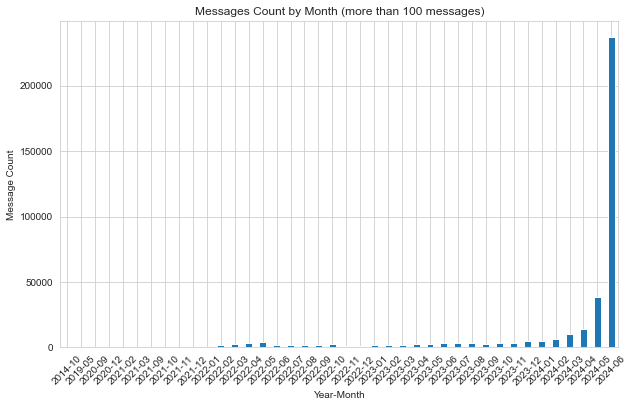

In [13]:
# The number of the messages per months
df_messages['year_month'] = df_messages['published_at'].dt.to_period('M')
messages_by_month = df_messages['year_month'].value_counts().sort_index()

# Filter out months with zero messages (if any)
messages_by_month = messages_by_month[messages_by_month > 100]
plt.figure(figsize=(10, 6))
messages_by_month.plot(kind="bar")
plt.title("Messages Count by Month (more than 100 messages)")
plt.xlabel("Year-Month")
plt.ylabel("Message Count")
plt.xticks(rotation=45)
plt.show()

### Lang detection

In [14]:
# Remove everything except for text, numbers and punctuation
punctuation = "!*(),-.:;?%\'\"\/"
russian_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
ukrainian_alphabet = u"АБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯабвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
latin_letters_numbers = "1234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ "
allowed_symbols = ukrainian_alphabet+russian_letters+latin_letters_numbers+punctuation

def clean_text(text, allowed_symbols=allowed_symbols):
    # Remove newline characters, carriage returns, and repr symbols
    cleaned_text = re.sub(r'[\n\r\t\\]+', ' ', text)
    # Remove multiple spaces 
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Clean the messages from all emojis
    pattern = r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251&&[^\uFF01-\uFF5E]]+'
    cleaned_text = re.sub(pattern, '', cleaned_text)
    # Remove URLs
    cleaned_text = re.sub(r'http[s]?://\S+', '', cleaned_text)
    getVals = list(filter(lambda x: x in allowed_symbols, cleaned_text))
    cleaned_text = "".join(getVals)
    cleaned_text = re.sub(' +', ' ', cleaned_text)
    return cleaned_text

In [15]:
# Clean messages text
df_messages["text_clean"] = df_messages["text"].apply(lambda x: clean_text(x))

C:\Windows\Temp\ipykernel_4408\1253194150.py:15: FutureWarning: Possible set intersection at position 232
  cleaned_text = re.sub(pattern, '', cleaned_text)


In [16]:
df_messages.head()

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type,year_month,text_clean
0,253122,1415474509,https://www.youtube.com/watch?v=eR9FIPXffUw&li...,945.0,21,3.0,0,2024-06-25 11:50:25,POST,2024-06,
1,253122,1408345528,Плохо спится в белую петербургскую ночь. Котор...,1429.0,164,3.0,1,2024-06-24 21:32:54,POST,2024-06,Плохо спится в белую петербургскую ночь. Котор...
2,253122,1394795522,"«Давайте посмотрим внимательно, какую свободу ...",1158.0,84,9.0,1,2024-06-23 11:33:04,POST,2024-06,"Давайте посмотрим внимательно, какую свободу п..."
3,253122,1364623985,К добрым словам Владимира Гельмана в мой адрес...,1071.0,86,2.0,0,2024-06-20 15:19:26,POST,2024-06,К добрым словам Владимира Гельмана в мой адрес...
4,253122,1364694325,"Известный политолог, профессор университета Хе...",1087.0,118,4.0,2,2024-06-20 15:14:28,POST,2024-06,"Известный политолог, профессор университета Хе..."


In [31]:
# Remove the messages that have less than 4 words
df_messages['length'] = df_messages['text_clean'].str.split().apply(len)
df_messages_length_5 = df_messages[df_messages['length'] > 4]

In [33]:
# Remove post earlier than 2022 year
df_messages_length_5 = df_messages_length_5[df_messages_length_5['published_at'] >= '2022-01-01']

In [4]:
def langdetect(text):
    try:
        language = detect(text)
    except:
        language = "none"
    return language

In [35]:
tqdm.pandas()
# Set up tqdm for pandas

df_messages_length_5["lang"] = df_messages_length_5["text_clean"].progress_apply(lambda x: langdetect(x))

100%|██████████| 338442/338442 [24:37<00:00, 229.03it/s]
C:\Windows\Temp\ipykernel_6712\1012886806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_messages_length_5["lang"] = df_messages_length_5["text_clean"].progress_apply(lambda x: langdetect(x))


In [40]:
df_messages_length_5.groupby("lang").size()

lang
af          55
bg        2095
ca         101
cs          14
cy          15
da          26
de        2231
en       35279
es        3525
et         269
fi         109
fr        1938
hr         625
hu         239
id         171
it        1295
lt          12
lv           6
mk        1307
nl         194
no          52
none       182
pl        2223
pt        1091
ro         186
ru      258873
sk         322
sl         137
so          47
sq           4
sv          35
sw          89
tl          37
tr         555
uk       25086
vi          17
dtype: int64

Text(0.5, 0, 'Language')

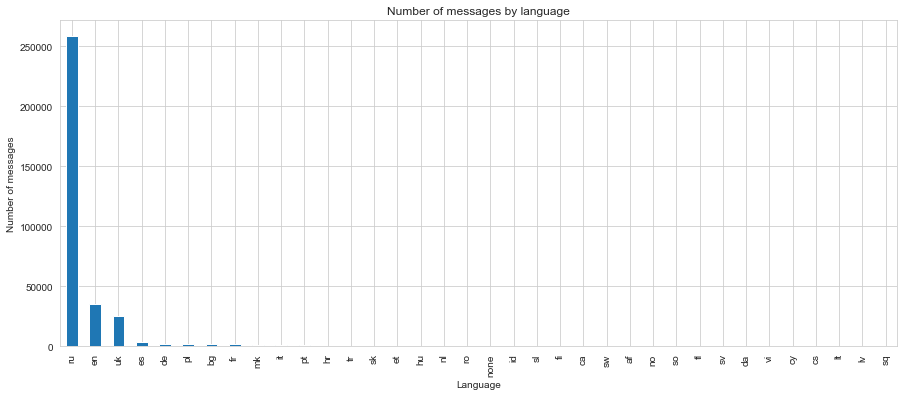

In [41]:
df_messages_length_5.lang.value_counts().plot(kind='bar', figsize=(15,6))
plt.title("Number of messages by language")
plt.ylabel('Number of messages')
plt.xlabel('Language')

In [46]:
# Take only the Russian and Ukrainian languages
df_messages_length_5_ru_ua = df_messages_length_5[(df_messages_length_5["lang"] == 'uk') | (df_messages_length_5["lang"] == 'ru')]

### Merge datasets

In [50]:
merged_df = pd.merge(df_messages_length_5_ru_ua, df_train, on='source_id', how='inner')

In [51]:
merged_df.head()

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type,lang,text_clean,length,source_url,source_category
0,253091,1428333721,Порядка 150 КОИБов планирует использовать ЦИК ...,1979.0,16,2.0,0,2024-06-26 10:13:14,POST,ru,Порядка 150 КОИБов планирует использовать ЦИК ...,25,https://t.me/cikrf,AGGRESSIVE_INFORMATION
1,253091,1428079971,ЦИК утвердил порядок гашения избирательных бюл...,10291.0,57,58.0,0,2024-06-26 10:00:05,POST,ru,ЦИК утвердил порядок гашения избирательных бюл...,72,https://t.me/cikrf,AGGRESSIVE_INFORMATION
2,253091,1428007536,Председатель ярославского избиркома Елена Нови...,2079.0,17,28.0,0,2024-06-26 09:30:21,POST,ru,Председатель ярославского избиркома Елена Нови...,37,https://t.me/cikrf,AGGRESSIVE_INFORMATION
3,253091,1428079972,Мандат умершего Артура Чилингарова — депутата ...,2321.0,22,4.0,0,2024-06-26 09:19:37,POST,ru,Мандат умершего Артура Чилингарова депутата Го...,50,https://t.me/cikrf,AGGRESSIVE_INFORMATION
4,253091,1427996535,ЦИК обнаружил трех «экстремистов/террористов» ...,2573.0,51,23.0,0,2024-06-26 08:31:57,POST,ru,ЦИК обнаружил трех экстремистов/террористов ср...,56,https://t.me/cikrf,AGGRESSIVE_INFORMATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201723,226841,776160744,Российские военные совместно с волонтерской ор...,512.0,0,0.0,0,2022-05-12 11:01:35,POST,ru,Российские военные совместно с волонтерской ор...,37,https://t.me/nosovka_ru,RESTRAINED_INFORMATION
201724,226841,776160747,Прибывшие после 19 февраля в Россию граждане У...,507.0,0,0.0,0,2022-05-12 07:52:56,REPOST,ru,Прибывшие после 19 февраля в Россию граждане У...,37,https://t.me/nosovka_ru,RESTRAINED_INFORMATION
201725,226841,775473825,"За сутки Россия эвакуировала более 1,1 тысячи ...",484.0,0,0.0,0,2022-05-11 17:32:09,REPOST,ru,"За сутки Россия эвакуировала более 1,1 тысячи ...",50,https://t.me/nosovka_ru,RESTRAINED_INFORMATION
201726,226841,775473830,Более 17 тысяч украинских беженцев пересекли р...,462.0,0,0.0,0,2022-05-11 15:39:43,REPOST,ru,Более 17 тысяч украинских беженцев пересекли р...,25,https://t.me/nosovka_ru,RESTRAINED_INFORMATION


In [53]:
merged_df["source_category"].value_counts(normalize=True) * 100

AGGRESSIVE_INFORMATION                  45.957924
RESTRAINED_INFORMATION                  35.001586
RESTRAINED_MILITARY                      3.645007
SAFE_CONTENT                             3.549829
AGGRESSIVE_MILITARY                      3.265784
UNRECOGNIZED_REPUBLICS                   2.144967
ENTITIES_PROMOTING_VIOLENCE_AND_HATE     1.954116
SPAM                                     1.702788
VIOLENCE                                 1.059843
COORDINATION_OF_ATTACKS                  0.737627
PERSONAL_INFORMATION                     0.693508
CYBER_ATTACK_COORDINATION                0.287020
Name: source_category, dtype: float64

In [58]:
merged_df["content_type"].value_counts()

POST       151580
REPOST      49548
COMMENT       600
Name: content_type, dtype: int64

In [52]:
# remove COMMENTS
merged_df = merged_df[(merged_df["content_type"] == "POST") | (merged_df["content_type"] == "REPOST") ]
merged_df["content_type"].value_counts()

POST      151580
REPOST     49548
Name: content_type, dtype: int64

#### Lematization

In [53]:
# Remove last sentence
def remove_last_sentence(text):
    sentences = sent_tokenize(text)
    if len(sentences) > 1:
        return ' '.join(sentences[:-1])
    else:
        return text  # Return the original text if there's only one sentence

# Initialize a tqdm progress bar
tqdm.pandas()

# Apply the function to the 'text' column
merged_df['text_clean_no_last'] = merged_df['text_clean'].progress_apply(remove_last_sentence)

100%|██████████| 201128/201128 [00:36<00:00, 5526.18it/s]
C:\Windows\Temp\ipykernel_15920\3529567991.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_clean_no_last'] = df['text_clean'].progress_apply(remove_last_sentence)


In [36]:
# Drop 100% dublicates
merged_df = merged_df.drop_duplicates(subset='text_clean_no_last')

In [54]:
len(merged_df)

201128

In [55]:
# Load the SpaCy models
nlp_ru = spacy.load("ru_core_news_md")
nlp_uk = spacy.load("uk_core_news_md")

# Simplified lemmatization function
def lemmatize_text(text, lang):
    nlp = nlp_ru if lang != 'uk' else nlp_uk
    doc = nlp(text)
    # return ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc if token.has_vector and (token.lemma_ or token.text)]).replace(',', '')
    return ' '.join([token.lemma_ for token in doc]).replace(',', '')


In [56]:
tqdm.pandas()
# Use tqdm to apply the function with a progress bar manually
lemmatized_texts = []
for index, row in tqdm(merged_df.iterrows(), total=merged_df.shape[0], desc="Lemmatizing"):
    lemmatized_texts.append(lemmatize_text(row['text_clean_no_last'], row['lang']))

merged_df['lemmatized_text'] = lemmatized_texts

Lemmatizing: 100%|██████████| 201128/201128 [1:32:48<00:00, 36.12it/s]  
C:\Windows\Temp\ipykernel_15920\2212626675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lemmatized_text'] = lemmatized_texts


In [59]:
merged_df.head()

,source_id,message_id,text,impressions,reactions,shares,comments,published_at,content_type,lang,text_clean,length,source_url,source_category,text_clean_no_last,lemmatized_text
0,253091,1428333721,Порядка 150 КОИБов планирует использовать ЦИК ...,1979.0,16,2.0,0,2024-06-26 10:13:14,POST,ru,Порядка 150 КОИБов планирует использовать ЦИК ...,25,https://t.me/cikrf,AGGRESSIVE_INFORMATION,Порядка 150 КОИБов планирует использовать ЦИК ...,порядок 150 коибов планировать использовать ци...
1,253091,1428079971,ЦИК утвердил порядок гашения избирательных бюл...,10291.0,57,58.0,0,2024-06-26 10:00:05,POST,ru,ЦИК утвердил порядок гашения избирательных бюл...,72,https://t.me/cikrf,AGGRESSIVE_INFORMATION,ЦИК утвердил порядок гашения избирательных бюл...,цик утвердить порядок гашение избирательный бю...
2,253091,1428007536,Председатель ярославского избиркома Елена Нови...,2079.0,17,28.0,0,2024-06-26 09:30:21,POST,ru,Председатель ярославского избиркома Елена Нови...,37,https://t.me/cikrf,AGGRESSIVE_INFORMATION,Председатель ярославского избиркома Елена Нови...,председатель ярославский избирком елена новик ...
3,253091,1428079972,Мандат умершего Артура Чилингарова — депутата ...,2321.0,22,4.0,0,2024-06-26 09:19:37,POST,ru,Мандат умершего Артура Чилингарова депутата Го...,50,https://t.me/cikrf,AGGRESSIVE_INFORMATION,Мандат умершего Артура Чилингарова депутата Го...,мандат умершего артур чилингаров депутат госду...
4,253091,1427996535,ЦИК обнаружил трех «экстремистов/террористов» ...,2573.0,51,23.0,0,2024-06-26 08:31:57,POST,ru,ЦИК обнаружил трех экстремистов/террористов ср...,56,https://t.me/cikrf,AGGRESSIVE_INFORMATION,ЦИК обнаружил трех экстремистов/террористов ср...,цик обнаружить три экстремист / террорист сред...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201723,226841,776160744,Российские военные совместно с волонтерской ор...,512.0,0,0.0,0,2022-05-12 11:01:35,POST,ru,Российские военные совместно с волонтерской ор...,37,https://t.me/nosovka_ru,RESTRAINED_INFORMATION,Российские военные совместно с волонтерской ор...,российский военный совместно с волонтёрский ор...
201724,226841,776160747,Прибывшие после 19 февраля в Россию граждане У...,507.0,0,0.0,0,2022-05-12 07:52:56,REPOST,ru,Прибывшие после 19 февраля в Россию граждане У...,37,https://t.me/nosovka_ru,RESTRAINED_INFORMATION,Прибывшие после 19 февраля в Россию граждане У...,прибыть после 19 февраль в россия гражданин ук...
201725,226841,775473825,"За сутки Россия эвакуировала более 1,1 тысячи ...",484.0,0,0.0,0,2022-05-11 17:32:09,REPOST,ru,"За сутки Россия эвакуировала более 1,1 тысячи ...",50,https://t.me/nosovka_ru,RESTRAINED_INFORMATION,"За сутки Россия эвакуировала более 1,1 тысячи ...",за сутки россия эвакуировать более 11 тысяча р...
201726,226841,775473830,Более 17 тысяч украинских беженцев пересекли р...,462.0,0,0.0,0,2022-05-11 15:39:43,REPOST,ru,Более 17 тысяч украинских беженцев пересекли р...,25,https://t.me/nosovka_ru,RESTRAINED_INFORMATION,Более 17 тысяч украинских беженцев пересекли р...,более 17 тысяча украинских беженец пересечь ро...


### Remove stop words

In [ ]:
# Remove stop words
# Завантаження стоп-слів для російської мови
stop_words_ru = stopwords.words('russian')
stop_words_ru.extend(['это', 'все', 'всё', 'пока', 'её','нам','подпишись'])

# Додавання власних стоп-слів для української мови
stop_words_uk = set([
    'і', 'в', 'не', 'я', 'що', 'на', 'з', 'до', 'це', 'у', 'це', 'за', 'як', 
    'по', 'його', 'так', 'але', 'вона', 'ми', 'вони', 'той', 'він', 'був', 
    'її', 'ще', 'їх', 'та', 'більш', 'більше', 'ніж', 'чи', 'про', 'бути', 
    'й', 'всі', 'також', 'ж', 'аби', 'жоден', 'аби', 'ні', 'же', 'ви'
])

# Комбінування стоп-слів
all_stop_words = stop_words_uk.union(set(stop_words_ru))

# Optimized Preprocessing with List Comprehension and Set Operations
def preprocess_hard(text, join_back=True):
    words = gensim.utils.simple_preprocess(text)
    filtered_words = [word for word in words if word not in all_stop_words]
    return " ".join(filtered_words) if join_back else filtered_words

merged_df['lemmatized_no_stopwords_text'] = merged_df['lemmatized_text'].apply(preprocess_hard)

### Remove most popular words

In [ ]:
# Find the most popular words
all_words = ' '.join(merged_df['lemmatized_no_stopwords_text']).split()
word_freq = Counter(all_words)

# Step 2: Identify the top 100 most frequent words
top_100_words = set([word for word, freq in word_freq.most_common(100)])
top_100_words.head()

In [ ]:
# Remove the most popular words
def remove_top_words(text):
    return ' '.join([word for word in text.split() if word not in top_100_words])


tqdm.pandas()
# Apply the function to remove the top 100 words
merged_df['text_no_popular'] = merged_df['lemmatized_no_stopwords_text'].progress_apply(remove_top_words)

In [58]:
merged_df.to_csv('preprocessed_data_11am.csv', index=False)